In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
from torchvision.utils import make_grid

from flows.autoregressive import MaskedAutoregressiveFlow
from utils import load_model

FLOW_PATH = 'logs/MAF-identity/version_0/'
MODEL_PATH = 'logs/DFCVAE/version_0/'
DATA_PATH = 'logs/DFCVAE/version_0/latent_space'

In [2]:
flow = load_model(FLOW_PATH).cuda()
model = load_model(MODEL_PATH, 'vae').cuda()

In [3]:
def summarise(z, y):
    z = torch.tensor(z.values, dtype=torch.float).cuda()

    y0 = torch.zeros(z.shape[0], 1).cuda()
    y1 = torch.ones(z.shape[0], 1).cuda()
    
    with torch.no_grad():
        res0 = flow.log_prob(z, y0).detach().cpu().numpy()
        res1 = flow.log_prob(z, y1).detach().cpu().numpy()
        
    df = pd.DataFrame({'res0': res0, 'res1': res1, 'y': y.values[:, 0]})
    df['y_hat'] = (df['res0'] < df['res1']).astype(int)
    
    print(confusion_matrix(df['y'], df['y_hat']))
    print(classification_report(df['y'], df['y_hat']))

    
def show_image(image):
    plt.figure(figsize = (16, 8))
    plt.imshow(image.squeeze(0).permute(1, 2, 0).detach().cpu())
    plt.show()

In [4]:
z_train = pd.read_csv(f'{DATA_PATH}/z_train.csv')
y_train = pd.read_csv(f'{DATA_PATH}/y_train_gender.csv')

z_valid = pd.read_csv(f'{DATA_PATH}/z_valid.csv')
y_valid = pd.read_csv(f'{DATA_PATH}/y_valid_gender.csv')

z_test = pd.read_csv(f'{DATA_PATH}/z_test.csv')
y_test = pd.read_csv(f'{DATA_PATH}/y_test_gender.csv')

## Image

In [5]:
n_samples = 20
n_row = 5

y0 = torch.zeros(1, 1).cuda()
y1 = torch.ones(1, 1).cuda()

with torch.no_grad():
    res0 = flow.sample(n_samples, y0)
    res1 = flow.sample(n_samples, y1)

res0_image = model.decode(res0)
res1_image = model.decode(res1)

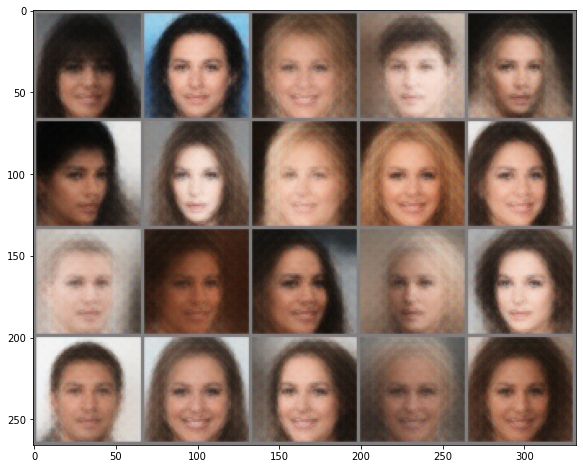

In [6]:
show_image((make_grid(res0_image, nrow = n_row) + 1) / 2)

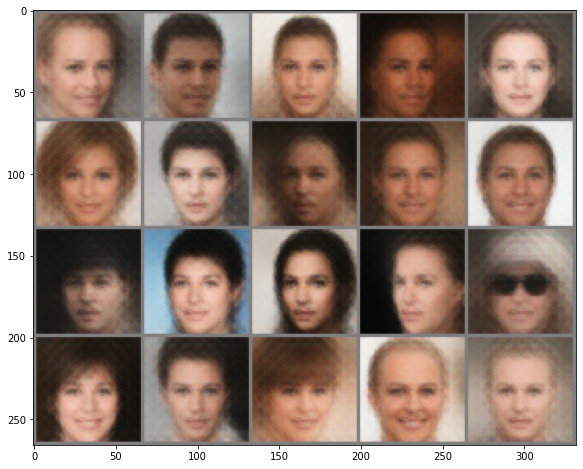

In [7]:
show_image((make_grid(res1_image, nrow = n_row) + 1) / 2)

## Classification

In [8]:
summarise(z_train, y_train)

[[78400 16109]
 [13421 54840]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     94509
           1       0.77      0.80      0.79     68261

    accuracy                           0.82    162770
   macro avg       0.81      0.82      0.81    162770
weighted avg       0.82      0.82      0.82    162770



In [9]:
summarise(z_valid, y_valid)

[[8908 2501]
 [2043 6415]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.80     11409
           1       0.72      0.76      0.74      8458

    accuracy                           0.77     19867
   macro avg       0.77      0.77      0.77     19867
weighted avg       0.77      0.77      0.77     19867



In [10]:
summarise(z_test, y_test)

[[9470 2777]
 [1911 5804]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80     12247
           1       0.68      0.75      0.71      7715

    accuracy                           0.77     19962
   macro avg       0.75      0.76      0.76     19962
weighted avg       0.77      0.77      0.77     19962

